In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta, timezone
import bz2
import json
import collections
from pprint import PrettyPrinter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from intervaltree import IntervalTree, Interval
from iso8601 import parse_date

from satbazaar import db


pprint = PrettyPrinter().pprint


In [4]:
#%%time
# NBVAL_IGNORE_OUTPUT

# script 'get-observations.py' generates this file
observations = db.load_observations()
satellites = db.load_satellites()

In [5]:
# construct histogram of observation count per satellite
# find earliest observation per sat for normalization
norad_hist = collections.defaultdict(int)

now = datetime.now(timezone.utc)
def recent():
    return now

norad_first = collections.defaultdict(recent)

for o in observations.values():
    norad = o['norad_cat_id']
    start = parse_date(o['start'])
    
    norad_hist[o['norad_cat_id']] += 1
    if start < norad_first[norad]:
        norad_first[norad] = start

In [6]:
# order dict by value
norad_hist = collections.OrderedDict(sorted(norad_hist.items(), key=lambda t: t[1], reverse=True))

# add known sats with no observations
for sat in satellites.values():
    norad = sat['norad_cat_id']
    if norad not in norad_hist:
        norad_hist[norad] = 0

In [7]:
norads, counts = zip(*norad_hist.items())

norad2name = {}
for norad, sat in satellites.items():
    norad2name[norad] = sat['name']

names = []
for i in sorted(norads):
    try:
        name = norad2name[i]
    except KeyError:
        print(i, 'missing')
        name = 'Unknown'
    names.append(name)


14129 missing
22825 missing
26063 missing
39381 missing
39436 missing
40897 missing
40948 missing
40949 missing
41474 missing
41477 missing
41478 missing
41895 missing
41909 missing
41915 missing
41931 missing
41934 missing
42702 missing
42737 missing
42770 missing
43133 missing
43485 missing
43553 missing
43656 missing
43681 missing
43721 missing
43722 missing
43738 missing
43743 missing
43758 missing
43768 missing
43770 missing
43772 missing
43773 missing
43780 missing
43782 missing
43784 missing
43786 missing
43787 missing
43790 missing
43792 missing
43793 missing
43798 missing
43803 missing
43804 missing
43805 missing
43809 missing
43814 missing
43855 missing
43856 missing
43857 missing
43879 missing
43880 missing
43881 missing
43908 missing
43933 missing
43935 missing
43937 missing
43940 missing
44030 missing
44045 missing
44046 missing
44083 missing
44103 missing
44104 missing
44109 missing
44329 missing
44330 missing
44331 missing
44332 missing
44339 missing
44352 missing
44354 

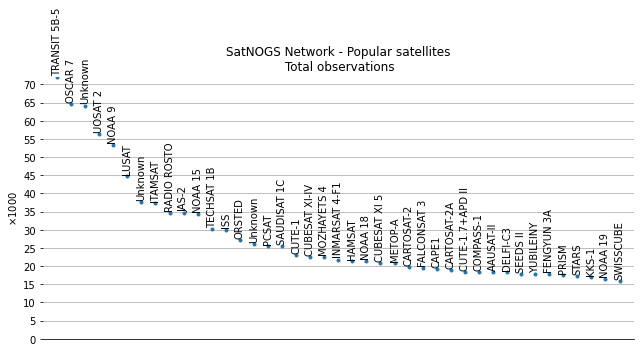

In [29]:
num_sats = 41
rescale = 1/1000
offset = 500 * rescale

fig, ax = plt.subplots(figsize=(9,5))

xa = np.array(x[:num_sats])
countsa = rescale * np.array(counts[:num_sats])

x = list(range(len(names)))
lines = ax.plot(xa, countsa, '.')




# add satellite name data labels
for i, name, count in zip(xa,
                          names[:num_sats],
                          countsa):
    ax.text(i, count+offset, name, rotation='vertical', ha='center', va='bottom')


# cleanup x axis junk
ax.set_xlim((-1, num_sats))
ax.set_xticks([])

# cleanup y axis
ymax = max(countsa)
ax.set_yticks(range(0, int(ymax), 5))
ax.set_ylim((0, ymax))
ax.set_ylabel(r'$\times 1000$')
# turn off borders
for pos in ('top', 'left', 'right'):
    ax.spines[pos].set_visible(False)

# construct a patch for clipping the gridlines
xy = list(zip(x, counts))
xy.insert(0, (-1, counts[0]))
xy.insert(0, (-1, 0))
xy.append((num_sats, 0))
path = mpl.path.Path(xy)
patch = mpl.patches.PathPatch(path, facecolor='none', edgecolor='none')

# add patch (necessary!) then clip grid lines
ax.add_patch(patch)
ax.grid(axis='y', clip_path=patch)

ax.set_title('SatNOGS Network - Popular satellites\n Total observations')

fig.tight_layout()
fig.savefig('popular-sats-all.png', dpi=300)


In [30]:
# normalize to average obs/day
for norad in norad_hist.keys():
    start = norad_first[norad]
    days = (now - start).total_seconds() / (60*60*24)
    if days != 0:
        norad_hist[norad] /= days
    else:
        norad_hist[norad] = 0
    
norad_hist = collections.OrderedDict(sorted(norad_hist.items(), key=lambda t: t[1], reverse=True))

norads, counts = zip(*norad_hist.items())

norad2name = {}
for norad, sat in satellites.items():
    norad2name[norad] = sat['name']

names = []
for i in norads:
    try:
        name = norad2name[i]
    except KeyError:
        print(i, 'missing')
        name = 'Unknown'
    names.append(name)


43770 missing
43803 missing
43792 missing
43780 missing
44332 missing
43793 missing
44330 missing
43937 missing
43786 missing
44109 missing
43879 missing
44365 missing
44878 missing
43908 missing
44030 missing
44329 missing
44103 missing
43743 missing
44426 missing
44420 missing
44387 missing
44356 missing
43880 missing
44359 missing
43881 missing
44045 missing
44331 missing
45119 missing
44354 missing
43855 missing
45263 missing
45258 missing
43721 missing
43768 missing
44083 missing
44427 missing
44830 missing
44429 missing
43814 missing
43738 missing
99831 missing
45261 missing
45598 missing
44406 missing
43805 missing
44404 missing
45262 missing
99801 missing
44394 missing
44104 missing
43804 missing
45115 missing
99961 missing
44419 missing
44832 missing
44355 missing
99964 missing
44392 missing
44352 missing
44360 missing
44854 missing
43787 missing
44885 missing
44530 missing
99809 missing
44829 missing
43784 missing
43758 missing
44369 missing
99817 missing
99821 missing
99814 

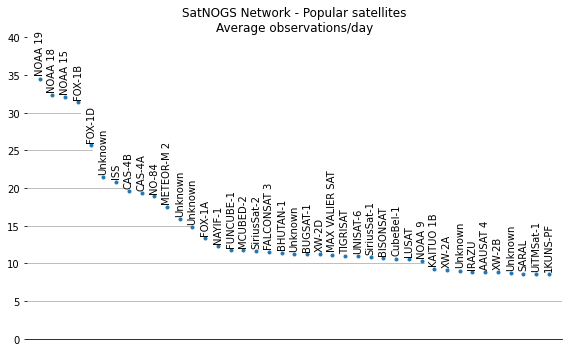

In [35]:
num_sats = 41
offset = 0.4

fig, ax = plt.subplots(figsize=(8,5))

x = list(range(len(names)))
lines = ax.plot(x[:num_sats], counts[:num_sats], '.')




# add satellite name data labels
for i, name, count in zip(x[:num_sats],
                          names[:num_sats],
                          counts[:num_sats]):
    ax.text(i, count+offset, name, rotation='vertical', ha='center', va='bottom')


# cleanup x axis junk
ax.set_xlim((-1, num_sats))
ax.set_xticks([])

# cleanup y axis
ax.set_yticks(range(0, 41, 5))
ax.set_ylim((0, 40))

# turn off borders
for pos in ('top', 'left', 'right'):
    ax.spines[pos].set_visible(False)

# construct a patch for clipping the gridlines
xy = list(zip(x, counts))
xy.insert(0, (-1, counts[0]))
xy.insert(0, (-1, 0))
xy.append((num_sats, 0))
path = mpl.path.Path(xy)
patch = mpl.patches.PathPatch(path, facecolor='none', edgecolor='none')

# add patch (necessary!) then clip grid lines
ax.add_patch(patch)
ax.grid(axis='y', clip_path=patch)

ax.set_title('SatNOGS Network - Popular satellites\nAverage observations/day')

fig.tight_layout()
fig.savefig('popular-sats-avg.png', dpi=300)
